# Notebook for analysing the univariate stats of all tables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')
 
from sqlalchemy import create_engine,text
user = 'root'
passwords = '7003890541'
host = 'localhost'
port = 3306
database = 'synthea'

engine = create_engine(f"mysql+pymysql://{user}:{passwords}@{host}:{port}/{database}")
def sql(query , engine = engine):
    return pd.read_sql(query,engine)


def select(table_name):
    return sql(f'select * from {table_name} limit 5')


def run(query):
    with engine.connect() as con:
        con.execute(text(query))
        con.commit()

In [2]:
imp_tables = [
    'encounters',
    'patients',
    'careplans',
    'conditions',
    'medications',
    'observations',
    'organizations',
    'procedures',
    'providers'
]

In [3]:
dict = {}
for tables in imp_tables:
    query = f'''
        select count(*) as row_count from {tables};
    '''
    df = sql(query)
    dict[tables] = df['row_count'][0]

pd.DataFrame.from_dict(dict,orient='index',columns=['row_count']).reset_index().rename(columns={'index':'table_name'})

,table_name,row_count
0,encounters,53346
1,patients,1171
2,careplans,3483
3,conditions,8376
4,medications,42989
5,observations,299697
6,organizations,1119
7,procedures,34981
8,providers,5855


`SO IT DOES NOT MEAN THAT EVERY ENCOUNTER CAN HAVE PROCEDURES, MEDICATIONS, CAREPLANS, OR DETECTED CONDITION`

**Fetch ALL Columns**

In [11]:
def fetch_all_cols(table):
    query = f'''
        select column_name from information_schema.columns
        where table_name = '{table}' and
        table_schema = database()
    '''
    df = sql(query)
    return df['COLUMN_NAME'].values.tolist()

**Find NULL Values**

In [ ]:
def find_nulls(table):
    dict ={}
    for col in fetch_all_cols(table):
        query = f'''
            select sum({col} is null) as {col}_nulls from {table}
        '''
        df =sql(query)
        dict[col] = df.iloc[0].values.astype('int')
    display(pd.DataFrame.
            from_dict(dict,orient='index',columns=['null_values']).
            reset_index().
            rename(columns={'index':'column_names'}))

**Plots a PIE CHART**

In [52]:
def pie_plot(columns,table_name):
    for col in columns:
        query = f'''
            select 
            {col},
            round(100*(count(*)/(select count(*) from {table_name})),2) as percentage
            from {table_name}
            group by {col}
            order by percentage desc
            limit 10;
        '''
        df = sql(query)
        plt.figure(figsize=(5,5))
        plt.pie(df['percentage'],labels=df[col].tolist(),autopct="%.2f%%",colors=plt.cm.Set3.colors,wedgeprops={'edgecolor':'black'})
        plt.title(f"Distribution of {col}",weight ='bold')
        plt.show()

**PLots a KDEPLOT**

In [68]:
def kde_plot(columns,table_name):
    for col in columns:
        query = f'''
            select {col} as {col} from {table_name};
        '''
        df = sql(query)
        mini = df[col].min()
        maxi = df[col].max()
        plt.figure(figsize=(24,5))
        sns.kdeplot(x=col,data=df,color= 'teal',fill=True)
        plt.axvline(mini,linestyle ='--',color = 'orange',label='minimum')
        plt.axvline(df[col].quantile(.25),linestyle ='--',color = 'black',label='25th')
        plt.axvline(df[col].mean(),linestyle ='--',color = 'blue',label = 'mean')
        plt.axvline(df[col].median(),linestyle ='--',color = 'red',label = 'median')
        plt.axvline(df[col].quantile(.75),linestyle ='--',color = 'green',label =' 75th')
        plt.axvline(maxi,linestyle ='--',color = 'orange',label='maxi')
        plt.legend(fontsize = 12)
        plt.grid(alpha = 1)
        plt.xticks(np.linspace(mini,maxi,20))
        plt.title(f"Distribution of {col}",weight = 'bold')
        plt.tight_layout()
        plt.show()

## Encounters

In [69]:
select('encounters').head(1)

,id,start,stop,patient,organization,provider,payer,class,description,basic_cost,total_cost,payer_coverage,reason
0,d0c40d10-8d87-447e-836e-99d26ad52ea5,2010-01-23 17:45:28,2010-01-23 18:10:28,034e9e3b-2def-4559-bb2a-7850888ae060,e002090d-4e92-300e-b41e-7d1f21dee4c6,e6283e46-fd81-3611-9459-0edb1c3da357,6e2f1a2d-27bd-3701-8d08-dae202c58632,ambulatory,encounter for symptom,129.16,129.16,54.16,acute bronchitis (disorder)


In [70]:
find_nulls('encounters')

,column_names,null_values
0,basic_cost,0
1,class,0
2,description,0
3,id,0
4,organization,0
5,patient,0
6,payer,0
7,payer_coverage,0
8,provider,0
9,reason,0


`NO NULL VALUES IN ENCOUNTERS TABLE`

In [76]:
sql(
    '''
    select count(*) as total_rows,
    count(distinct id) as total_unique_id ,
    count(distinct patient) as total_unique_patient,
    count(distinct organization) as total_unique_organization,
    count(distinct provider) as total_unique_provider,
    count(distinct payer) as total_unique_payer
    from encounters
'''
)

,total_rows,total_unique_id,total_unique_patient,total_unique_organization,total_unique_provider,total_unique_payer
0,53346,53346,1171,1103,1104,10


`THERE IS NO DUPLICATE ID`

`PATIENT RECORD OF 1171 USERS ARE PRESENT`

`1103 RECORDS OF ORGANIZATION IS PRESENT`

`1104 TOTAL PROVIDER RECORD IS PRESENT`

In [78]:
sql(
    '''
    select timestampdiff(YEAR,min(start),max(start)) as range_of_data_in_years from encounters
'''
)

,range_of_data_in_years
0,107


`DATA OF 107 LONG YEARS ARE PRESENT THERE`

In [71]:
fetch_all_cols('encounters')

['basic_cost',
 'class',
 'description',
 'id',
 'organization',
 'patient',
 'payer',
 'payer_coverage',
 'provider',
 'reason',
 'start',
 'stop',
 'total_cost']

In [72]:
cat_cols = ['class','description','reason',]
num_cols = ['basic_cost','total_cost','payer_coverage']

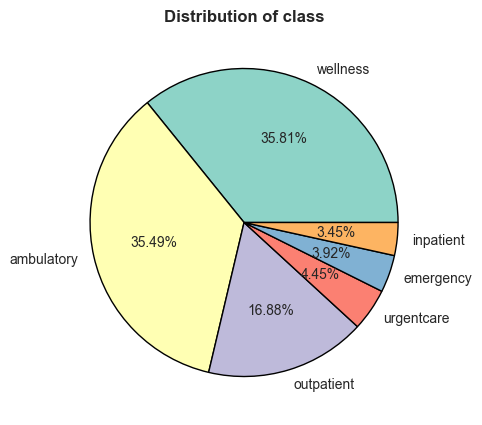

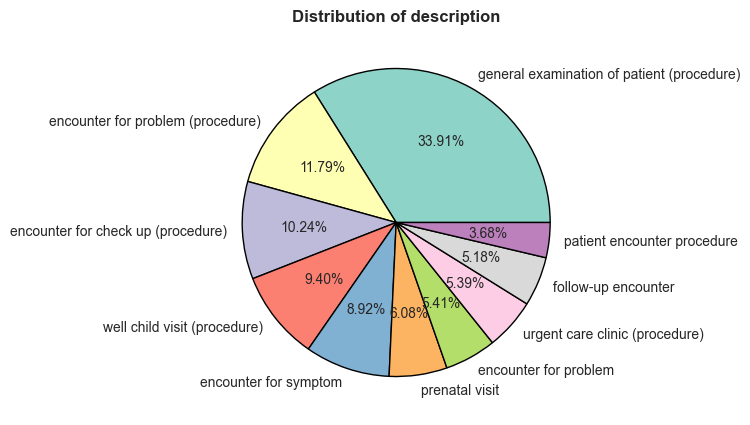

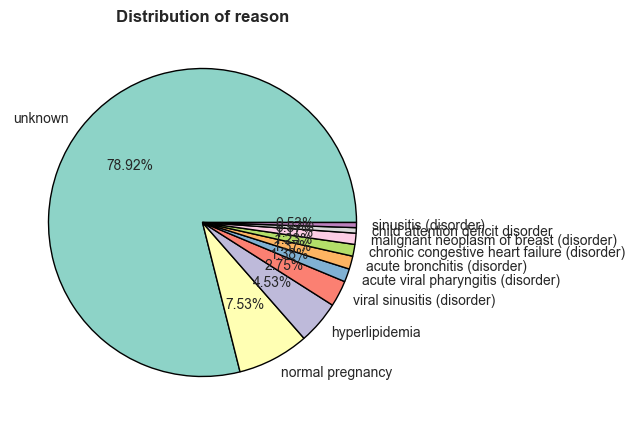

In [73]:
pie_plot(cat_cols,'encounters')

`APPROX 70% OF PEOPLE COME FOR ROUTINE CHECKUP OR NORMAL ILLNESS`

`MOST PATIENTS COME FOR GENERAL EXAMINATION`

`MOST OF THE REASON IS UNKNOWN IN THE DATA`

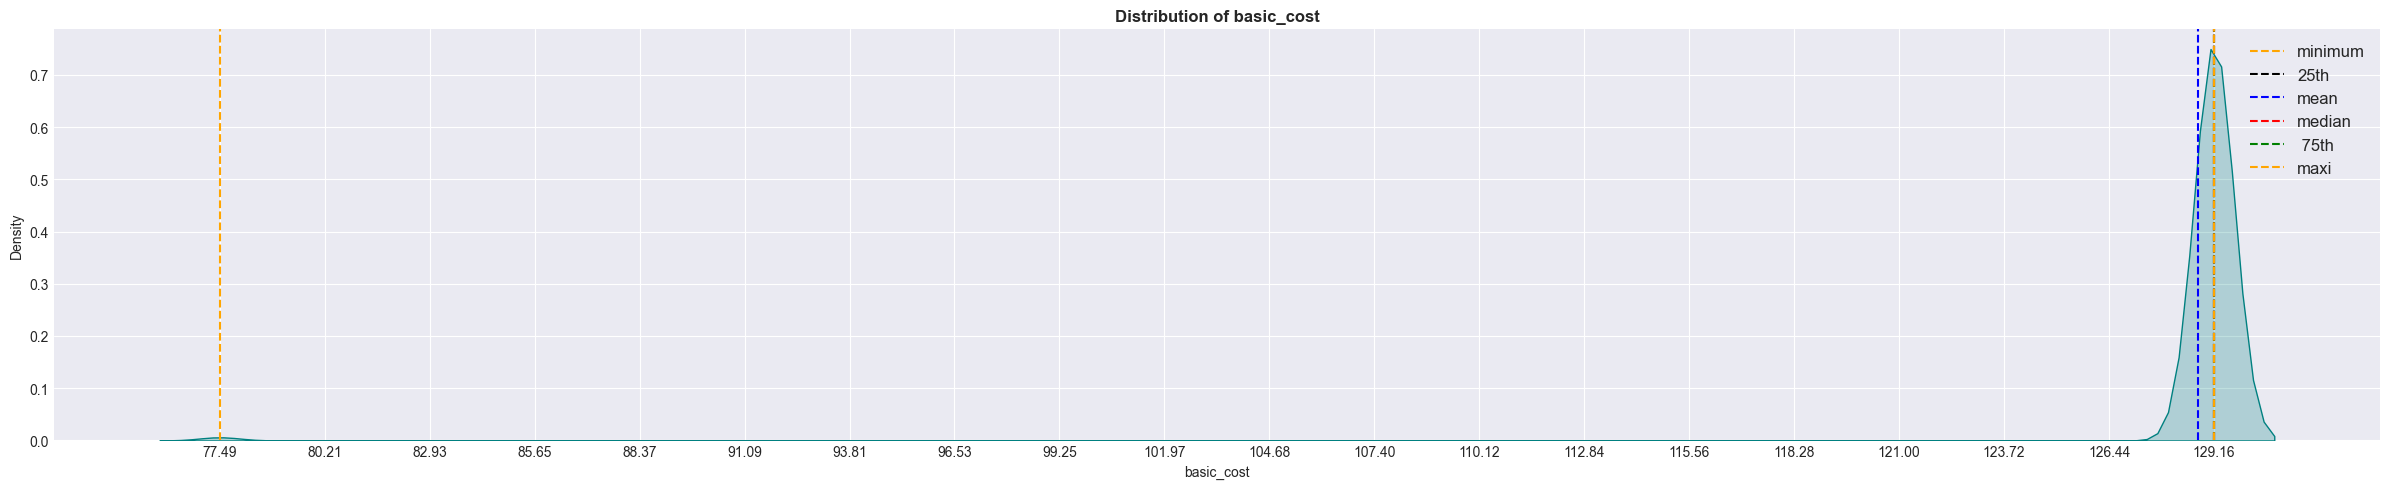

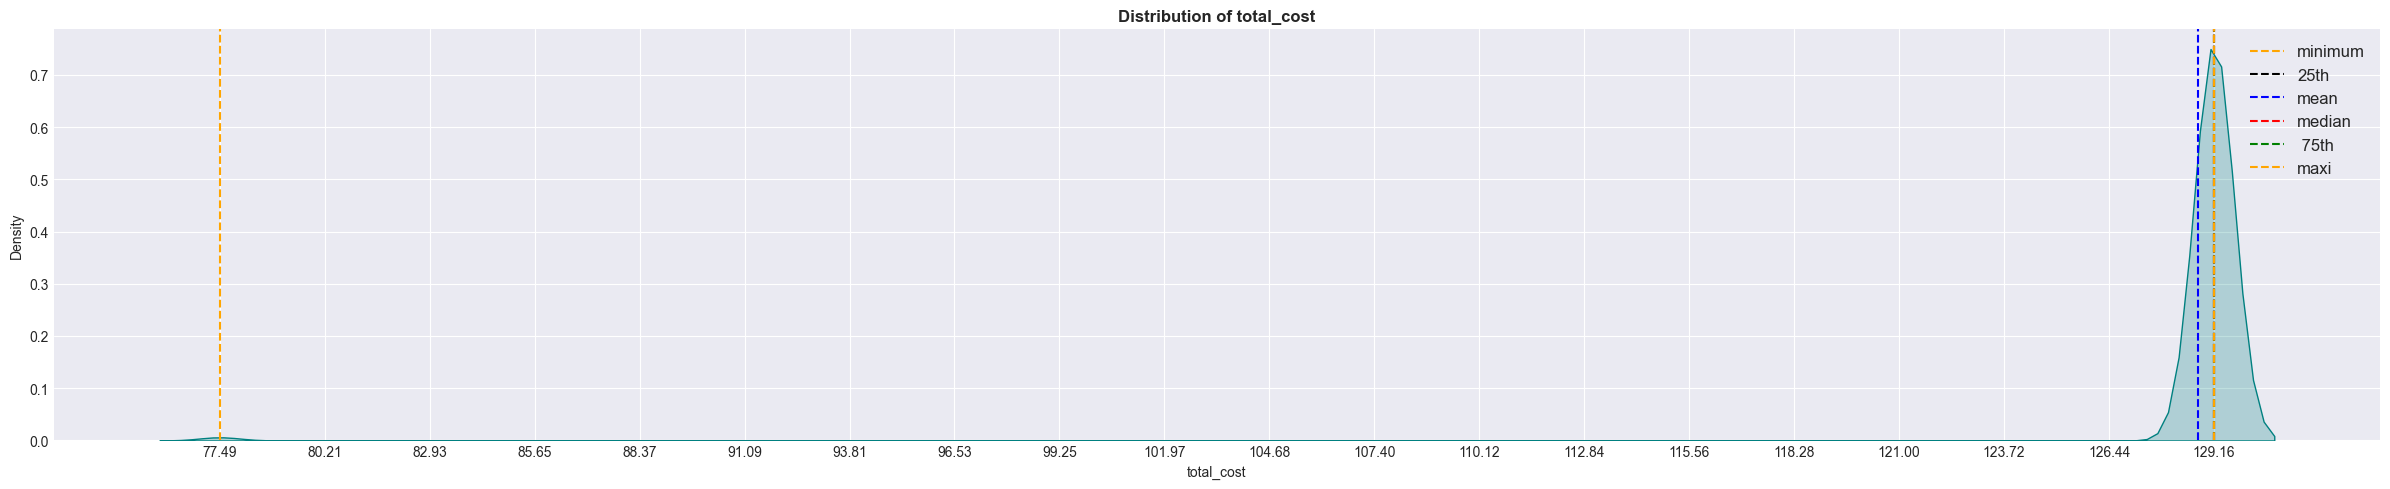

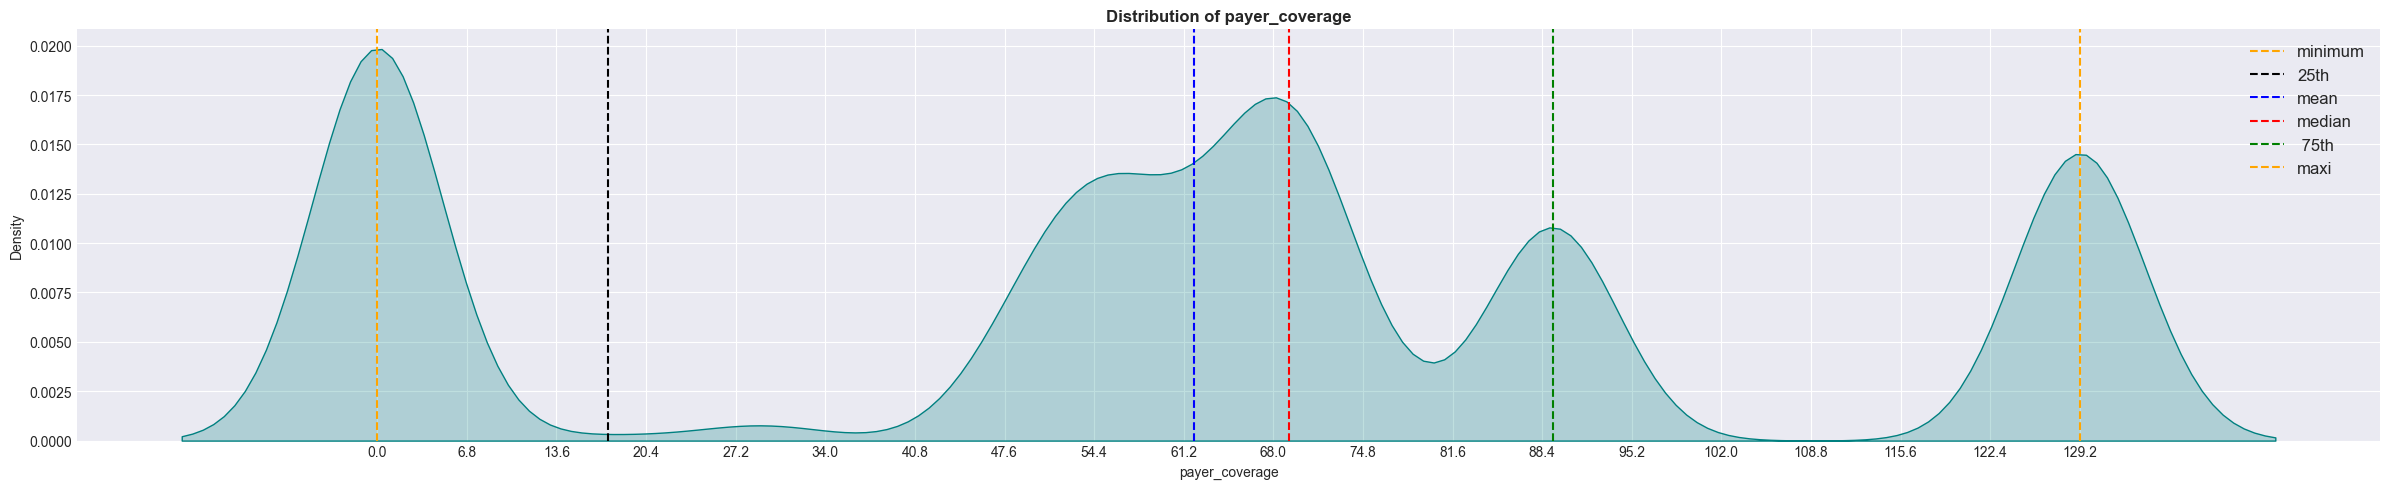

In [74]:
kde_plot(num_cols,'encounters')

## Careplans

In [79]:
select('careplans').head(1)

,id,start,stop,patient,encounter,description,reason
0,d2500b8c-e830-433a-8b9d-368d30741520,2010-01-23,2012-01-23,034e9e3b-2def-4559-bb2a-7850888ae060,d0c40d10-8d87-447e-836e-99d26ad52ea5,respiratory therapy,acute bronchitis (disorder)


In [80]:
find_nulls('careplans')

,column_names,null_values
0,description,0
1,encounter,0
2,id,0
3,patient,0
4,reason,0
5,start,0
6,stop,1532


`THERE ARE 1532 NULL VALUES, IT IS POSSIBLE THAT THEY ARE STILL IN ANY CAREPLAN`

In [92]:
careplan_duration = sql(
    '''
    select datediff(stop,start) as difference
    from careplans
    where stop is not null;
'''
)

In [103]:
careplan_duration.describe().round(2)

,difference
count,1951.00
mean,193.42
std,584.35
min,1.00
25%,21.00
50%,60.00
75%,217.00
max,10203.00


`HALF OF THE CAREPLANS HAVE DURATION OF 2 MONTHS ONLY, VERY FEW HAVE LONG DURATION OR CAREPLANS`

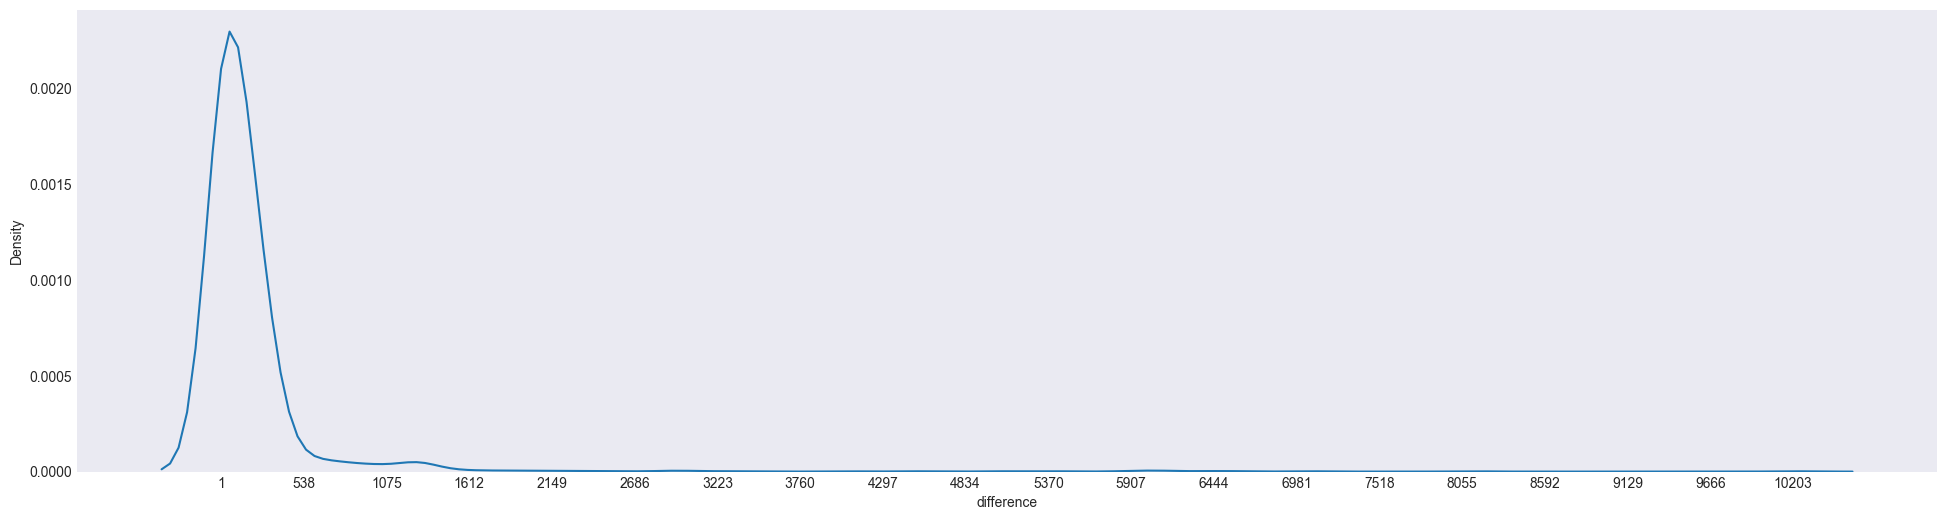

In [101]:
plt.figure(figsize=(24,6))
sns.kdeplot(careplan_duration['difference'])
plt.xticks(np.linspace(careplan_duration['difference'].min(),careplan_duration['difference'].max(),20))
plt.show()

In [81]:
fetch_all_cols('careplans')

['description', 'encounter', 'id', 'patient', 'reason', 'start', 'stop']

In [82]:
cat_cols = ['description', 'reason']

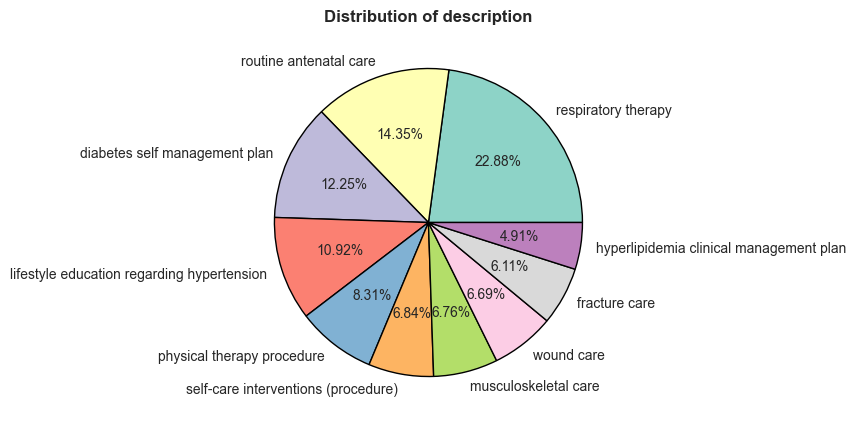

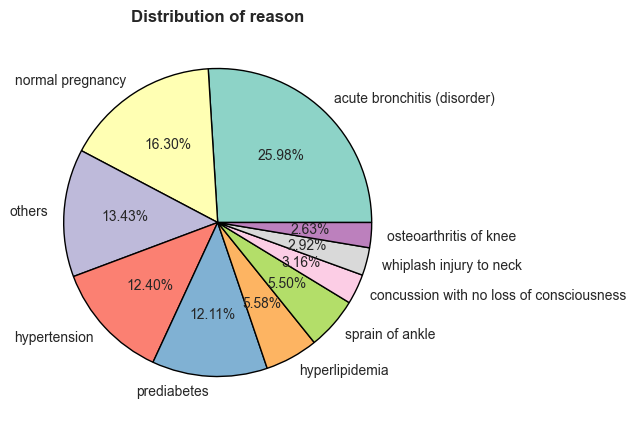

In [83]:
pie_plot(cat_cols,'careplans')

`MOST OF THE CAREPLANS ARE RESPIRATORY THERAPY`

`MOST NUMBER OF REASON FOR CAREPLAN IS ACUTE BRONCHITIS DISORDER`

## Conditions

In [104]:
select('conditions').head(1)

,start,stop,patient,encounter,description
0,2001-05-01,None,1d604da9-9a81-4ba9-80c2-de3375d59b40,8f104aa7-4ca9-4473-885a-bba2437df588,chronic sinusitis (disorder)


In [105]:
find_nulls('conditions')

,column_names,null_values
0,description,0
1,encounter,0
2,patient,0
3,start,0
4,stop,3811


`STOP COLUMN HAVE NULL VALUES, MAYBE THERE AER SOME CONDITION WHICH IS NOT CURED YET`

In [107]:
sql('SELECT MIN(START) AS MIN_START, MAX(START) AS MAX_START FROM CONDITIONS')

,MIN_START,MAX_START
0,1916-12-28,2020-04-25


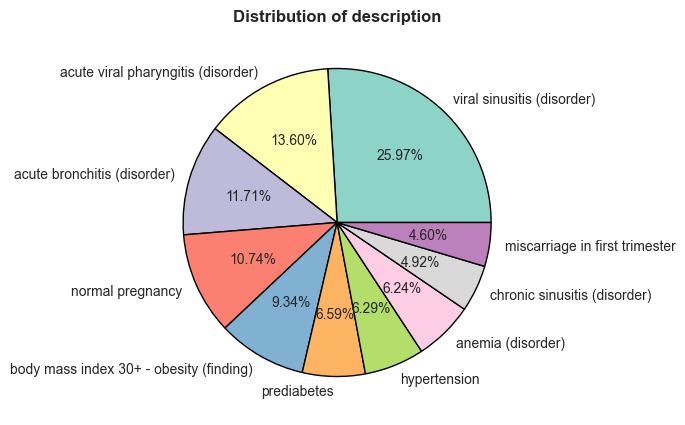

In [106]:
pie_plot(['description'],'conditions')

`MOST OF THE DETECTED CONDITION IS VIRAL SINUSITIS DISORDER`

## Medications

In [108]:
select('medications').head(1)

,start,stop,patient,payer,encounter,medicine_code,base_cost,payer_coverage,dispenses,total_cost,reason
0,2010-05-05 00:26:23,2011-04-30 00:26:23,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,1e0d6b0e-1711-4a25-99f9-b1c700c9b260,389221,677.08,0.0,12,8124.96,unknown


In [109]:
find_nulls('medications')

,column_names,null_values
0,base_cost,0
1,dispenses,0
2,encounter,0
3,medicine_code,0
4,patient,0
5,payer,0
6,payer_coverage,0
7,reason,0
8,start,0
9,stop,1895


`THERE ARE NULL VALUES IN MEDICATIONS COLUMN, MAYBE THERE ARE SOME ONGOING MEDICATION PERIOD`

In [111]:
fetch_all_cols('medications')

['base_cost',
 'dispenses',
 'encounter',
 'medicine_code',
 'patient',
 'payer',
 'payer_coverage',
 'reason',
 'start',
 'stop',
 'total_cost']

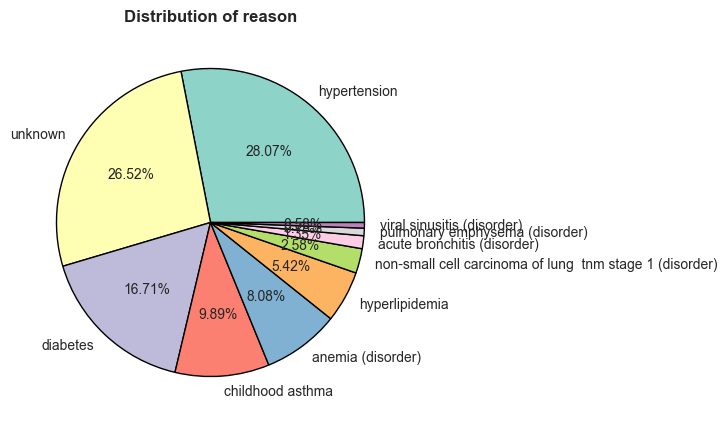

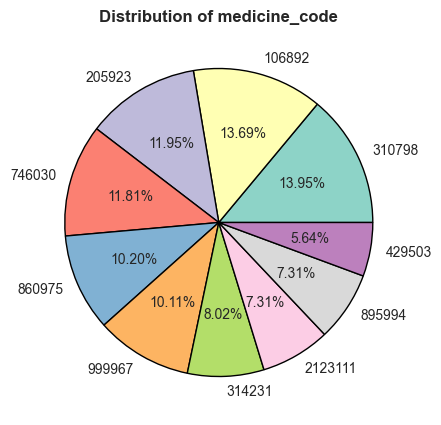

In [115]:
pie_plot(['reason','medicine_code'],'medications')

`MOSTLY THE MEDICATION IS PROVIDED FOR HYPERTENSION, AND HIGH NUMBER OF VALUES ARE UNKNOWN`

In [123]:
sql('select total_cost,base_cost from medications').describe().round(2)

,total_cost,base_cost
count,42989.00,42989.00
mean,2328.65,320.44
std,12591.05,772.84
min,0.99,0.99
25%,263.49,65.76
50%,526.98,263.49
75%,3161.88,263.49
max,1296594.95,7015.80


`BASE COST MAX IS 7015, BUT TOTAL COST BECOMES 12LAKHS+`

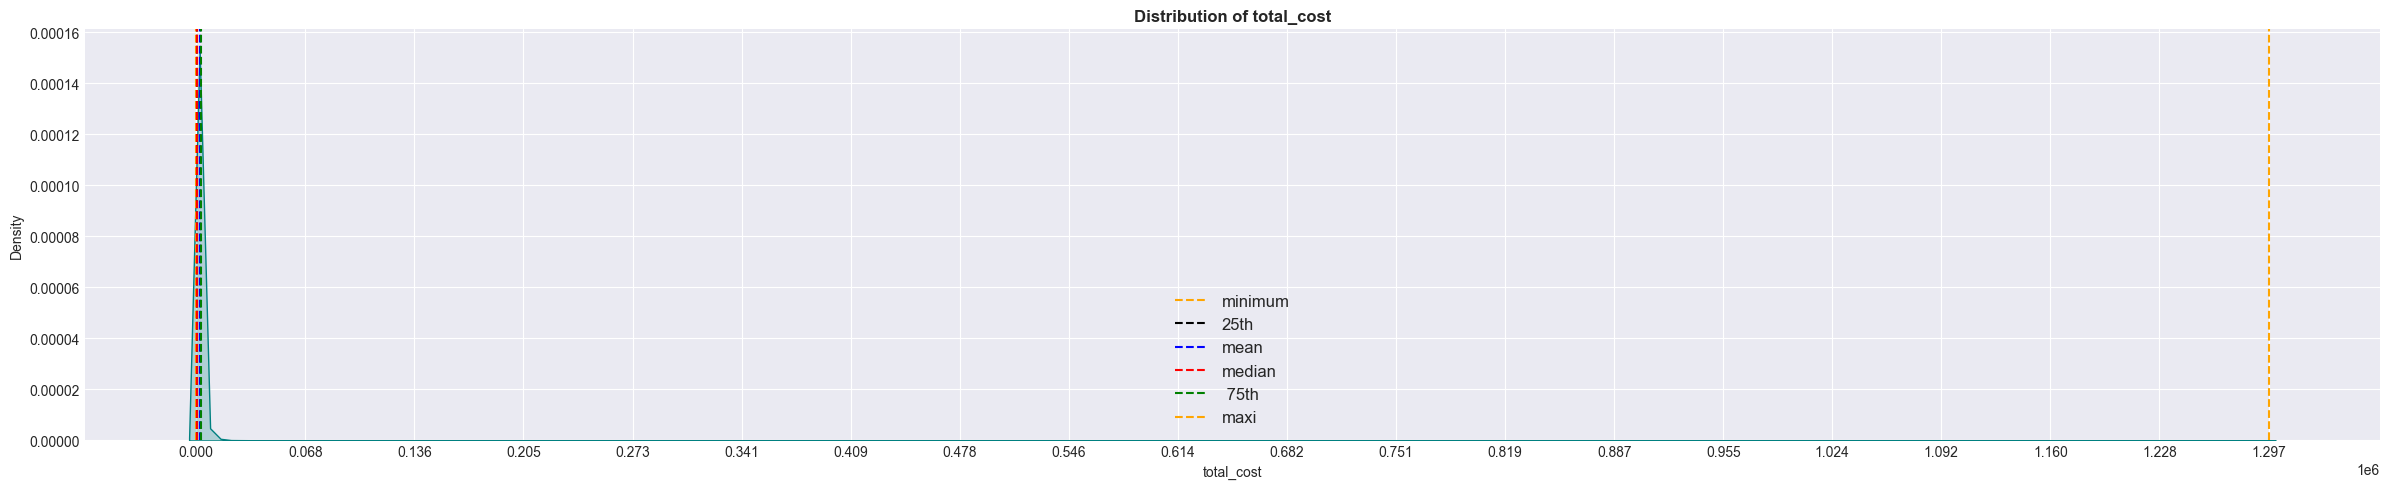

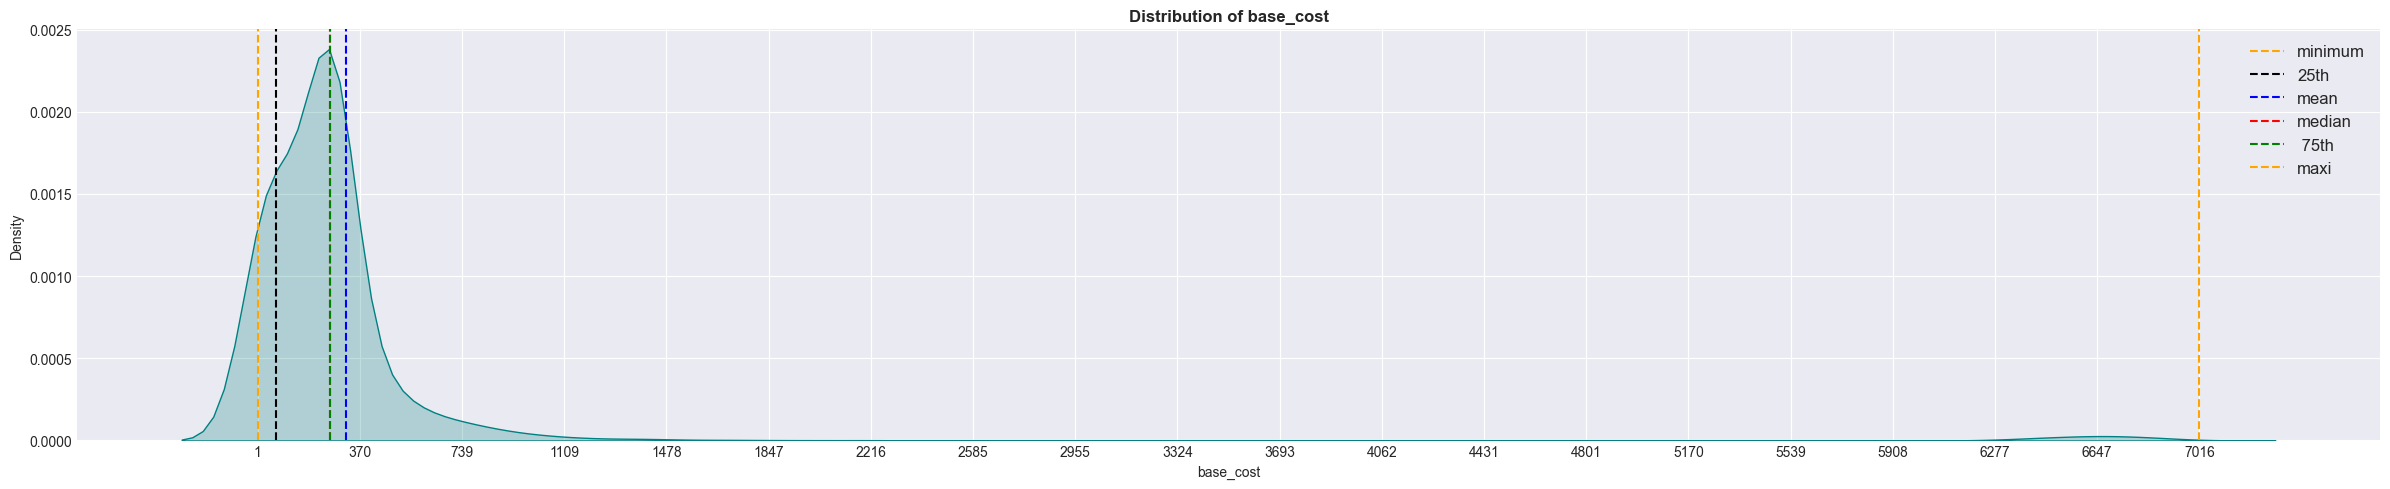

In [121]:
kde_plot(['total_cost','base_cost'],'medications')

`THERE ARE OUTLIERS IN MEDICINE PRICE`

<Axes: >

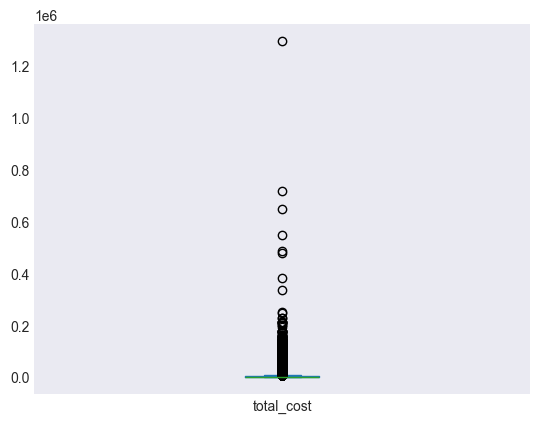

In [125]:
sql('select total_cost from medications').plot(kind='box')

`VERY FEW OUTILERS AT THE HIGHER END`

<Axes: >

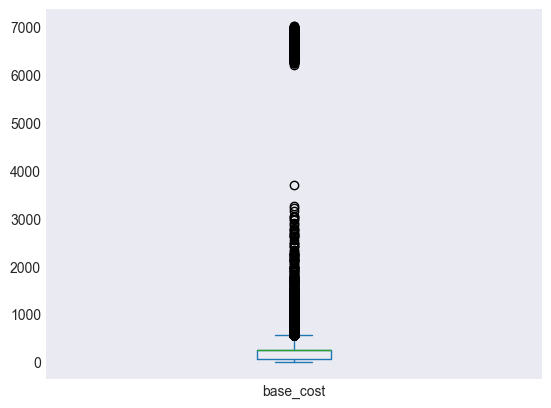

In [126]:
sql('select base_cost from medications').plot(kind='box')

`VERY FEW MEDICATION HAVE HIGHER BASE COST`

## Observations

In [127]:
select('observations').head(1)

,date,patient,encounter,description,value,units,type
0,2012-01-23,034e9e3b-2def-4559-bb2a-7850888ae060,e88bc3a9-007c-405e-aabc-792a38f4aa2b,body height,193.3,cm,numeric


In [128]:
find_nulls('observations')

,column_names,null_values
0,date,0
1,description,0
2,encounter,30363
3,patient,0
4,type,0
5,units,12735
6,value,0


In [130]:
sql('select patient from observations where encounter is null').value_counts()

patient                             
0047123f-12e7-486c-82df-53b3a450e365    33
023a7d29-32b3-4db5-89c8-b88bd7582ec0    33
02ea2f1a-ddcf-4809-8279-dde7a62e0318    33
d7d1f837-a2c8-4648-b498-a02278b91a08    33
d9f90c91-2e37-40ca-a574-89b33a120d16    33
                                        ..
ef544417-a448-4c9d-8ddf-cb7fb513061d     3
49cc8ae0-debc-428b-918c-75d3a635a19b     3
293afb6b-b727-445a-a5b5-1c7a419ba7e2     3
271943ef-e257-48cd-aa9a-b3a685f0572b     3
09cbb3f1-c2ed-426c-8c53-ffda77efcb08     3
Name: count, Length: 1056, dtype: int64

`THERE ARE PATIENTS WITH OBSERVATION WITHOUT ANY ENCOUNTER`

## Organizations

In [131]:
select('organizations').head(1)

,id,name,city,state,revenue,utilization
0,ef58ea08-d883-3957-8300-150554edc8fb,healthalliance hospitals inc,leominster,ma,198002.28,1557


In [132]:
find_nulls('organizations')

,column_names,null_values
0,city,0
1,id,0
2,name,0
3,revenue,0
4,state,0
5,utilization,0


In [135]:
sql('SELECT COUNT(DISTINCT ID) AS TOTAL_UNIQUE_ORGANIZATIONS, COUNT(*) AS TOTAL_ROWS FROM ORGANIZATIONS')

,TOTAL_UNIQUE_ORGANIZATIONS,TOTAL_ROWS
0,1119,1119


`THERE ARE NO DUPLICATE ORGANIZATION`

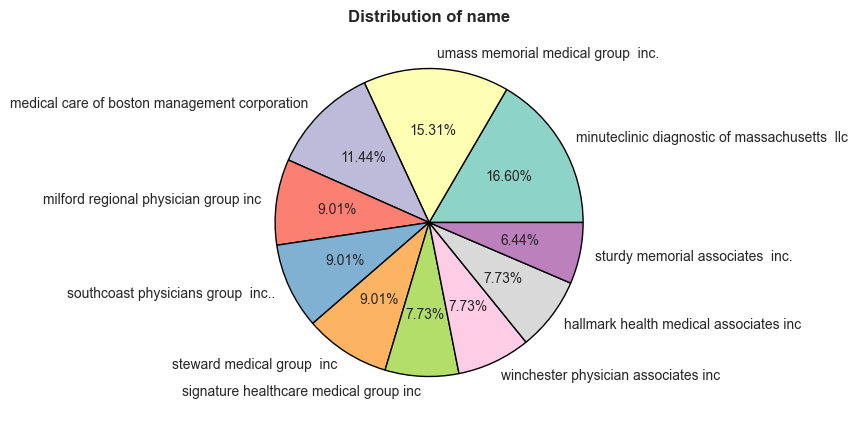

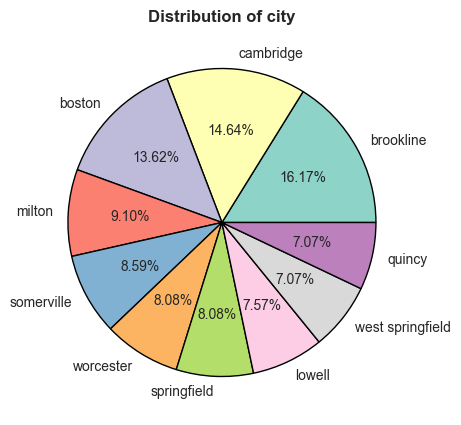

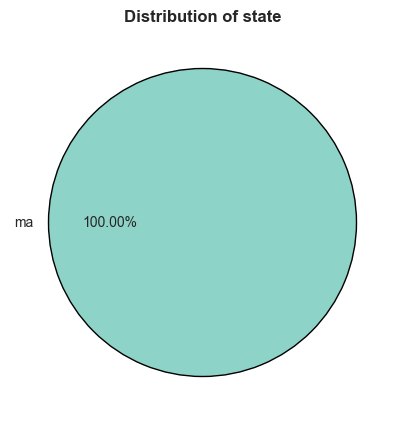

In [133]:
pie_plot(['name','city','state'],'organizations')

`THERE IS ONLY 1 STATE VALUE`

`ORGANIZATIONS ARE NOT LIMITED TO A CERTAIN CITY OR CERTAIN PLACE`

## Procedures

In [136]:
select('procedures').head(1)

,date,patient,encounter,description,base_cost,reason
0,2011-04-30t00:26:23z,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,6aa37300-d1b4-48e7-a2f8-5e0f70f48f38,insertion of subcutaneous contraceptive,14896.56,unknow


In [137]:
find_nulls('procedures')

,column_names,null_values
0,base_cost,0
1,date,0
2,description,0
3,encounter,0
4,patient,0
5,reason,0


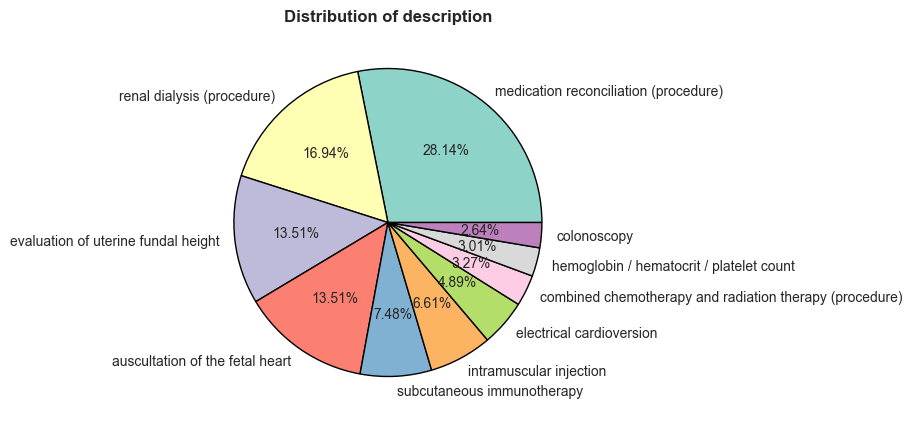

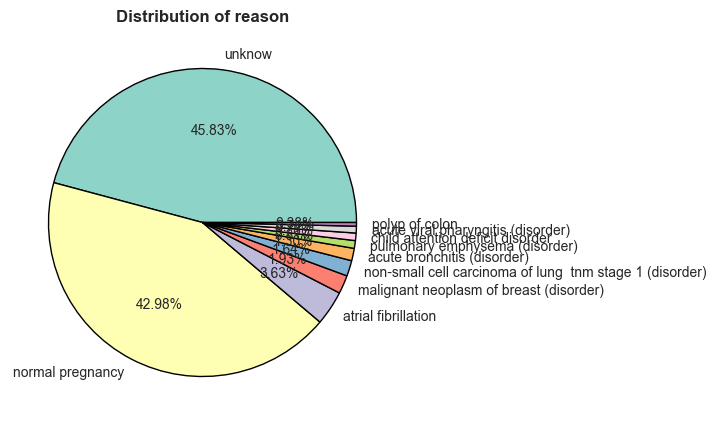

In [138]:
pie_plot(['description','reason'],'procedures')

`MOSTLY REASON OF PROCEDURES ARE NORMAL PREGNANCY AND SOME UNKNOWN REASON`

## Providers

In [139]:
select('providers')

,id,organization,gender,speciality,city,state,utilization
0,3421aa75-dec7-378d-a9e0-0bc764e4cb0d,ef58ea08-d883-3957-8300-150554edc8fb,m,general practice,leominster,ma,1557
1,c9b3c857-2e24-320c-a79a-87b8a60de63c,69176529-fd1f-3b3f-abce-a0a3626769eb,f,general practice,cambridge,ma,2296
2,0359f968-d1a6-30eb-b1cc-e6cc0b4d3513,5e765f2b-e908-3888-9fc7-df2cb87beb58,f,general practice,attleboro,ma,2287
3,446d1609-858f-3a54-8a52-0c4eacedd00e,f1fbcbfb-fcfa-3bd2-b7f4-df20f1b3c3a4,f,general practice,lawrence,ma,1327
4,e6283e46-fd81-3611-9459-0edb1c3da357,e002090d-4e92-300e-b41e-7d1f21dee4c6,f,general practice,cambridge,ma,3199


In [140]:
find_nulls('providers')

,column_names,null_values
0,city,0
1,gender,0
2,id,0
3,organization,0
4,speciality,0
5,state,0
6,utilization,0


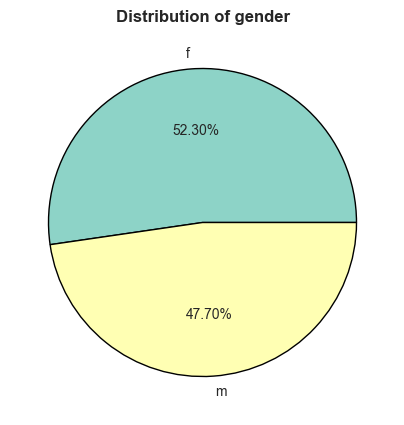

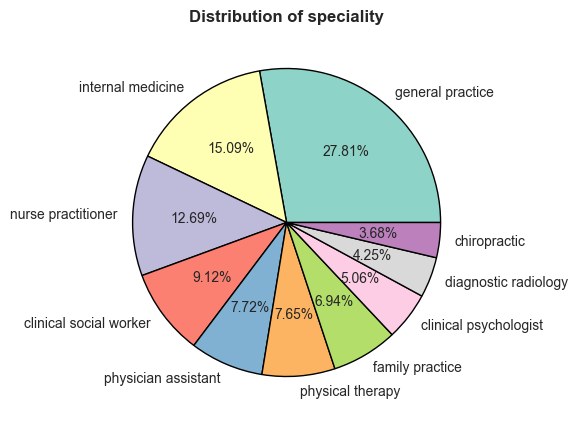

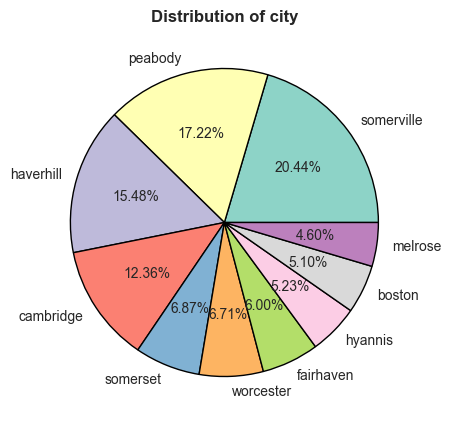

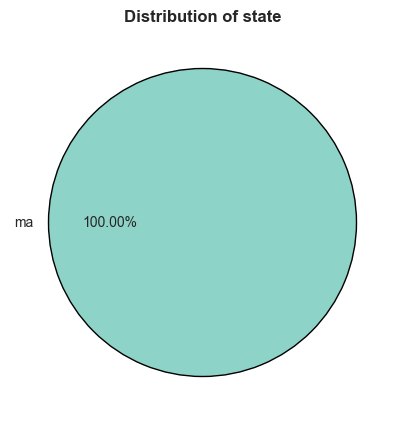

In [141]:
pie_plot(['gender','speciality','city','state'],'providers')

`MOSTLY PROVIDERS BELONGS T0 GENERAL PRACTICE OR MEDICINES`

`50% OF PROVIDERS ARE FROM 3 CITIES ONLY`